HW2 code

zhao xinyi 19307110452

In [7]:
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib
from PIL import Image


def plotImage(Img,new_img,method_text):
    
    plt.subplot(121)
    plt.title('origin')
    plt.imshow(Img, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('after')
    plt.imshow(new_img, cmap='gray')
    plt.axis('off')
    plt.show()

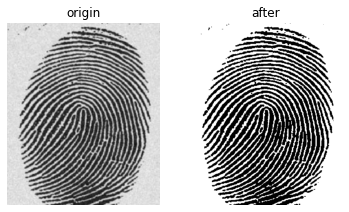

In [9]:
#Problem 1

def BGT(img):
    T_initial = np.min(img) /2+ np.max(img)/2
    curr_T = int(np.ceil(T_initial)) # round
    hist = np.zeros(256)
    counter = Counter(img.reshape(-1)) # count frequency
    for i in range(256):
        hist[i] = counter[i]
    hist = hist / np.sum(hist) # get frequency hist
 
    # begin iteration
    for i in range(10000):
        # calculate the mean of BG and FG
        w_bg = np.sum(hist[:curr_T]) # probability of BG
        vec_bg = np.array(range(curr_T)) # form vectors of gray value
        mu_bg = vec_bg.dot(hist[:curr_T]) # dot with frequency
        mu_bg = mu_bg / w_bg if w_bg else 0 # get prob

        w_fg = np.sum(hist[curr_T:]) # probability of FG
        vec_fg = np.array(np.arange(curr_T, 256))
        mu_fg = vec_fg.dot(hist[curr_T:])
        mu_fg = mu_fg / w_fg if w_fg else 0

        next_T = int(np.ceil((mu_bg + mu_fg) / 2)) # new mean
        if next_T ==curr_T: # finish iteration condition
            final_T = next_T 
            new_img = (img > final_T) * 255 #separate image to 0-1 gray
            return new_img

        curr_T = next_T # next iteration

    print('max iteration exceed')#max iteration exceed 

#read image
img = np.array(Image.open("finger.jpg").convert('L'),np.uint8) 
new_img = BGT(img)    
plotImage(img, new_img,'BGT') 

In [10]:
# problem 2

def update_hist(center_pixel, img,previous_hist,side_length):
    # update hist based on past pixel
    (x, y) = center_pixel # pixel center
    half_patch = (side_length - 1) // 2
    if center_pixel == (half_patch, half_patch):    # first pixel
        newhist = Counter(img[:side_length, :side_length].reshape(-1))
    # z-shaped scanning
    if (x - half_patch) % 2 == 0:
        if y == half_patch:  # when x even: move down
            newhist =  previous_hist + Counter(img[x + half_patch, :side_length]) \
            - Counter(img[x - 1 - half_patch, :side_length])
            return newhist
        else: # move on right
            newhist = previous_hist + Counter(img[(x - half_patch):(x + half_patch + 1), y + half_patch]) \
                - Counter(img[(x - half_patch):(x + half_patch + 1), y - 1 - half_patch])
            return newhist
    pic_width = np.size(img, 1)
    if y == pic_width - half_patch - 1:  # when x odd, move down
        newhist = previous_hist + Counter(img[x + half_patch, pic_width - side_length:]) \
            - Counter(img[x - 1 - half_patch, pic_width - side_length:])
        return newhist
    else: # move on left
        newhist = previous_hist + Counter(img[(x - half_patch):(x + half_patch + 1), y - half_patch]) \
            - Counter(img[(x - half_patch):(x + half_patch + 1), y + half_patch + 1])
        return newhist



In [38]:
def local_threshold(img, len_patch, alg):
    height, width = img.shape
    half_patch = (len_patch - 1) // 2 
    tempImg = np.zeros((height + len_patch - 1, width + len_patch - 1))  # a larger temp matrix
    tempImg[half_patch: height + half_patch, half_patch: width + half_patch] = img
    new_img = np.zeros((height + len_patch - 1, width + len_patch - 1))
    local_hist = Counter() # local histogram
    for x in range(half_patch, height + half_patch):
        Y_order = range(half_patch, width + half_patch)
        if (x - half_patch) % 2:
            Y_order = reversed(Y_order) # z-shape movement window
        for y in Y_order: # 
            curr_patch = img[x - half_patch:x + half_patch + 1, y - half_patch:y + half_patch + 1].flatten()  # current data scanned
            patch_max = np.max(curr_patch)   # max and min gray value in current patch
            patch_min = np.min(curr_patch)
            criterion_value = np.zeros(256)
            local_hist = update_hist((x, y), tempImg, local_hist, len_patch) # get current hist
            hist = np.zeros(256)
            for threshold in range(256):
                hist[threshold] = local_hist[threshold]
            hist = hist/np.sum(hist) # get hist
            for threshold in range(patch_min,patch_max+1):
                w0 = np.sum(hist[:threshold]) # frontground
                w1 = np.sum(hist[threshold:]) # background
                if alg == 'OSTU_hist':
                    u0 = np.array(range(threshold)).dot(hist[:threshold]) / w0 if w0 else 0 # mean of frontground
                    u1 = np.array(np.arange(threshold,256)).dot(hist[threshold:]) / w1 if w1 else 0 # mean of background
                    criterion_value[threshold] = w0 * w1 * (u0-u1)**2 # var between groups
                if alg == 'entropy':
                    prob_bg = hist[:threshold]/w0 if w0 else np.zeros(threshold) # probs of each group
                    prob_fg = hist[threshold:]/w1 if w1 else np.zeros(255-threshold)
                    prob_bg[np.where(prob_bg==0)] = 1.0 # normalization for easy calculate
                    prob_fg[np.where(prob_fg==0)] = 1.0
                    h0 = np.array(prob_bg).dot(np.log2(prob_bg)) # cal entropy
                    h1 = np.array(prob_fg).dot(np.log2(prob_fg))
                    criterion_value[threshold]=-h0-h1

            best_threshold = np.argmax(criterion_value) # choose max value for best threshold
            new_img[x][y] = tempImg[x][y] >= best_threshold  # relationship between the current center point and threshold

    new_img = new_img[half_patch:height + half_patch, half_patch:width + half_patch] # get new image
    return new_img * 255

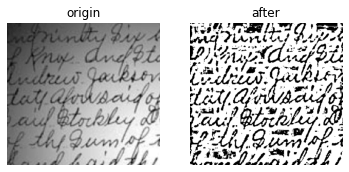

In [39]:
# 1.BGT
# img = np.array(Image.open("letter_small.jpg").convert('L')) 
# new_img = BGT(img)    
# plotImage(img, new_img,'BGT') 

# 2.OSTU_hist
# img = np.array(Image.open("letter_small.jpg").convert('L'))
# new_img = local_threshold(img, 25, 'OSTU_hist')  # after processing
# plotImage(img,new_img,'OSTU')

# 3.entropy
img = np.array(Image.open("letter_small.jpg").convert('L'))
new_img = local_threshold(img, 19, 'entropy')  # after processing
plotImage(img,new_img,'entropy')



In [43]:
# problem 3
def bilinear_intercept(img, N):
    # bilinear intercept algorithm
    height, width = img.shape
    new_height, new_width = int(height * N), int(width * N) # new height and width of image
    new_img = np.zeros((new_height, new_width))
    prop_of_height, prop_of_Width = (height - 1) / (new_height- 1), (width - 1) / (new_width - 1) # proportion of resize

    # add margin with zero value
    temp_img = np.zeros((height+1, width+1))
    temp_img[0 : height,0 :width] = img

    for i in range(new_height):
        for j in range(new_width): # for each pixel
            neigh_i, neigh_j = int(i * prop_of_height), int(j * prop_of_Width)   # nearest neighbor
            u, v = i * prop_of_height - neigh_i, j * prop_of_Width - neigh_j # estimate the intensity at given locations
            new_img[i][j] = u * v * temp_img[neigh_i + 1][neigh_j + 1] + (1 - u) * (1 - v) * temp_img[neigh_i][neigh_j] + \
                           u * (1 - v) * temp_img[neigh_i + 1][neigh_j] +(1 - u) * v * temp_img[neigh_i][neigh_j + 1]   
                           # interpolation 
    return new_img

(45, 47)


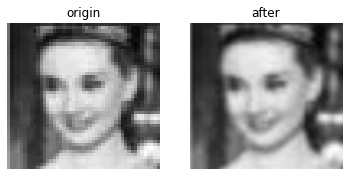

In [45]:
img = np.array(Image.open("herpen3.jpg").convert('L'))
print(img.shape)
new_img = bilinear_intercept(img, 10)  # after processing
plotImage(img,new_img,'entropy')